In [29]:
from keras.datasets.mnist import load_data
from matplotlib import pyplot
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras.utils.vis_utils import plot_model
from numpy import expand_dims
from numpy import ones
from numpy import zeros
from numpy.random import rand
from numpy.random import randn
from numpy.random import randint
from keras.layers import Reshape
from numpy import vstack
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose

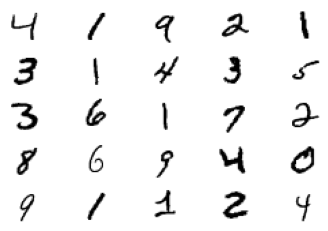

In [3]:
# load the images into memory
(trainX, trainy), (testX, testy) = load_data()
# plot images from the training dataset
for i in range(25):
	# define subplot
	pyplot.subplot(5, 5, 1 + i)
	# turn off axis
	pyplot.axis('off')
	# plot raw pixel data
	pyplot.imshow(trainX[i], cmap='gray_r')
pyplot.show()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        640       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0

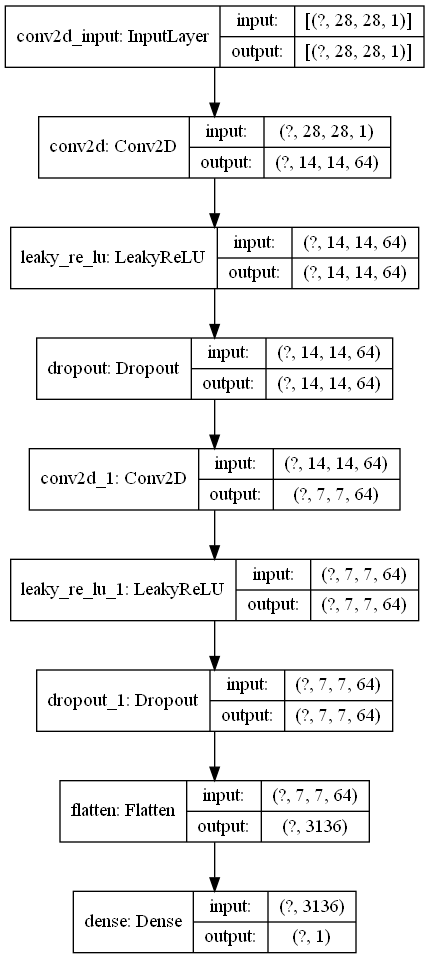

In [5]:
# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1)):
	model = Sequential()
    
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
    
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
    
	model.add(Flatten())
	model.add(Dense(1, activation='sigmoid'))
    
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    
	return model
 
# define model
model = define_discriminator()

# summarize the model
model.summary()

# plot the model
plot_model(model, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

#### The images are 2D arrays of pixels and convolutional neural networks expect 3D arrays of images as input, where each image has one or more channels.
#### We must update the images to have an additional dimension for the grayscale channel. We can do this using the expand_dims() NumPy function and specify the final dimension for the channels-last image format.
#### Finally, we must scale the pixel values from the range of unsigned integers in [0,255] to the normalized range of [0,1].


In [6]:
# load and prepare mnist training images
def load_real_samples():
	# load mnist dataset
	(trainX, _), (_, _) = load_data()
    
	# expand to 3d, e.g. add channels dimension
	X = expand_dims(trainX, axis=-1)
        
	# convert from unsigned ints to floats
	X = X.astype('float32')
    
	# scale from [0,255] to [0,1]
	X = X / 255.0
    
	return X

In [7]:
# The generate_real_samples() function below will take the training dataset as an argument 
# and will select a random subsample of images; it will also return class labels for the sample,
# specifically a class label of 1, to indicate real images.

# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
    
	# retrieve selected images
	X = dataset[ix]
    
	# generate 'real' class labels (1)
	y = ones((n_samples, 1))
    
	return X, y

In [8]:
# The generate_fake_samples() function below implements this behavior and 
# generates images of random pixel values and their associated class label of 0, for fake.

# generate n fake samples with class labels
def generate_fake_samples(n_samples):
	# generate uniform random numbers in [0,1]
	X = rand(28 * 28 * n_samples)
    
	# reshape into a batch of grayscale images
	X = X.reshape((n_samples, 28, 28, 1))
    
	# generate 'fake' class labels (0)
	y = zeros((n_samples, 1))
    
	return X, y

In [11]:
# train the discriminator model
def train_discriminator(model, dataset, n_iter=100, n_batch=256):
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_iter):
		# get randomly selected 'real' samples
		X_real, y_real = generate_real_samples(dataset, half_batch)
        
		# update discriminator on real samples
		_, real_acc = model.train_on_batch(X_real, y_real)
        
		# generate 'fake' examples
		X_fake, y_fake = generate_fake_samples(half_batch)
        
		# update discriminator on fake samples
		_, fake_acc = model.train_on_batch(X_fake, y_fake)
        
		# summarize performance
		print('>%d real=%.0f%% fake=%.0f%%' % (i+1, real_acc*100, fake_acc*100))

# define the discriminator model
model = define_discriminator()

# load image data
dataset = load_real_samples()

# fit the model
train_discriminator(model, dataset)

# In this case, the discriminator model learns to tell the difference between 
# real and randomly generated MNIST images very quickly, in about 50 batches.

>1 real=61% fake=4%
>2 real=79% fake=20%
>3 real=72% fake=22%
>4 real=70% fake=43%
>5 real=71% fake=65%
>6 real=64% fake=82%
>7 real=77% fake=90%
>8 real=73% fake=96%
>9 real=73% fake=100%
>10 real=78% fake=100%
>11 real=74% fake=100%
>12 real=76% fake=100%
>13 real=81% fake=100%
>14 real=78% fake=100%
>15 real=80% fake=100%
>16 real=80% fake=100%
>17 real=83% fake=100%
>18 real=78% fake=100%
>19 real=77% fake=100%
>20 real=85% fake=100%
>21 real=86% fake=100%
>22 real=88% fake=100%
>23 real=88% fake=100%
>24 real=95% fake=100%
>25 real=94% fake=100%
>26 real=95% fake=100%
>27 real=94% fake=100%
>28 real=93% fake=100%
>29 real=95% fake=100%
>30 real=98% fake=100%
>31 real=98% fake=100%
>32 real=100% fake=100%
>33 real=100% fake=100%
>34 real=99% fake=100%
>35 real=99% fake=100%
>36 real=99% fake=100%
>37 real=100% fake=100%
>38 real=100% fake=100%
>39 real=100% fake=100%
>40 real=100% fake=100%
>41 real=100% fake=100%
>42 real=100% fake=100%
>43 real=100% fake=100%
>44 real=100% fake=1

# How to Define and Use the Generator Model

In [ ]:
### The generator model is responsible for creating new, fake but plausible images of handwritten digits.
### Inputs: Point in latent space, e.g. a 100 element vector of Gaussian random numbers.
### Outputs: Two-dimensional square grayscale image of 28×28 pixels with pixel values in [0,1].

# Note: we don’t have to use a 100 element vector as input; it is a round number and widely used, 
# but I would expect that 10, 50, or 500 would work just as well.

# Developing a generator model requires that we transform a vector from the latent space with, 
# 100 dimensions to a 2D array with 28×28 or 784 values.

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 6272)              633472    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 128)       262272    
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 28, 28, 128)      

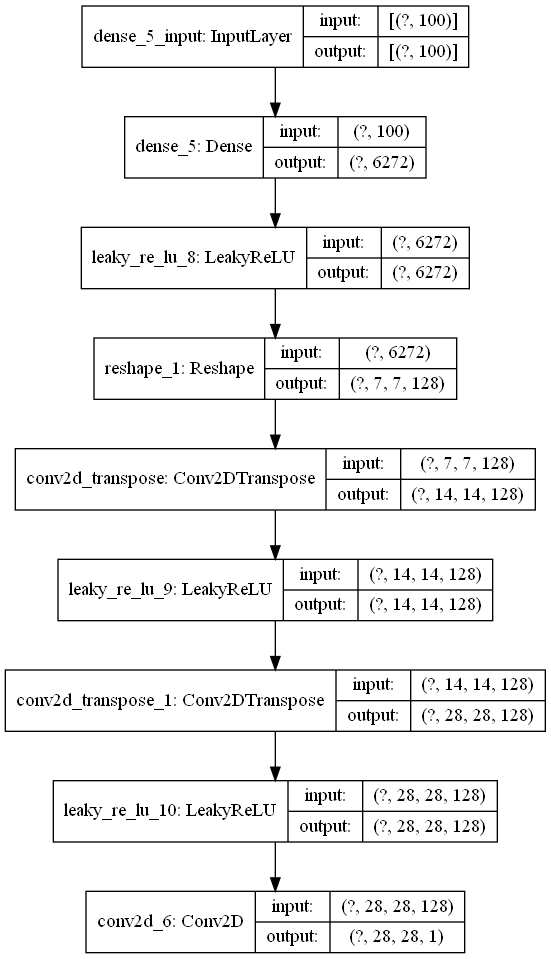

In [16]:
# define the standalone generator model
def define_generator(latent_dim):
	model = Sequential()
    
	# foundation for 7x7 image 
	n_nodes = 128 * 7 * 7
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((7, 7, 128)))
    
	# upsample to 14x14
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
    
	# upsample to 28x28
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
    
	return model
 
# define the size of the latent space
latent_dim = 100

# define the generator model
model = define_generator(latent_dim)

# summarize the model
model.summary()

# plot the model
plot_model(model, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)

In [17]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
    
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
    
	return x_input

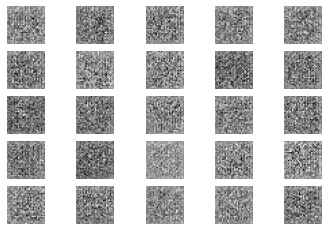

In [20]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y
 
# size of the latent space
latent_dim = 100

# define the discriminator model
model = define_generator(latent_dim)

# generate samples
n_samples = 25
X, _ = generate_fake_samples(model, latent_dim, n_samples)

# plot the generated samples
for i in range(n_samples):
	# define subplot
	pyplot.subplot(5, 5, 1 + i)
	# turn off axis labels
	pyplot.axis('off')
	# plot single image
	pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
    
# show the figure
pyplot.show()

# How to Train the Generator Model

The weights in the generator model are updated based on the performance of the discriminator model.
When the discriminator is good at detecting fake samples,
the generator is updated more, and when the discriminator model is relatively poor or confused when detecting fake samples, 
the generator model is updated less.

In [21]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
    
	# connect them
	model = Sequential()
    
	# add generator
	model.add(g_model)
    
	# add the discriminator
	model.add(d_model)
	# compile model
    
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
    
	return model

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_9 (Sequential)    (None, 28, 28, 1)         1164289   
_________________________________________________________________
sequential_8 (Sequential)    (None, 1)                 40705     
Total params: 1,204,994
Trainable params: 1,164,289
Non-trainable params: 40,705
_________________________________________________________________


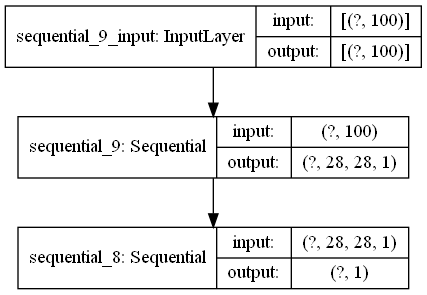

In [22]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# summarize gan model
gan_model.summary()
# plot gan model
plot_model(gan_model, to_file='gan_plot.png', show_shapes=True, show_layer_names=True)

In [23]:
# train the composite model
def train_gan(gan_model, latent_dim, n_epochs=100, n_batch=256):
	# manually enumerate epochs
	for i in range(n_epochs):
		# prepare points in latent space as input for the generator
		x_gan = generate_latent_points(latent_dim, n_batch)
		# create inverted labels for the fake samples
		y_gan = ones((n_batch, 1))
		# update the generator via the discriminator's error
		gan_model.train_on_batch(x_gan, y_gan)

In [25]:
# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, epoch, n=10):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
	# save plot to file
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	pyplot.savefig(filename)
	pyplot.close()

In [26]:
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	# save plot
	save_plot(x_fake, epoch)
	# save the generator model tile file
	filename = 'generator_model_%03d.h5' % (epoch + 1)
	g_model.save(filename)

In [27]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=256):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# create training set for the discriminator
			X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
			# update discriminator model weights
			d_loss, _ = d_model.train_on_batch(X, y)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
		# evaluate the model performance, sometimes
		if (i+1) % 10 == 0:
			summarize_performance(i, g_model, d_model, dataset, latent_dim)

In [ ]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

>1, 1/234, d=0.687, g=0.774
>1, 2/234, d=0.677, g=0.796
>1, 3/234, d=0.669, g=0.823
>1, 4/234, d=0.661, g=0.838
>1, 5/234, d=0.654, g=0.863
>1, 6/234, d=0.651, g=0.875
>1, 7/234, d=0.641, g=0.889
>1, 8/234, d=0.633, g=0.904
>1, 9/234, d=0.635, g=0.898
>1, 10/234, d=0.631, g=0.893
>1, 11/234, d=0.636, g=0.870
>1, 12/234, d=0.644, g=0.842
>1, 13/234, d=0.647, g=0.809
>1, 14/234, d=0.651, g=0.781
>1, 15/234, d=0.648, g=0.759
>1, 16/234, d=0.649, g=0.743
>1, 17/234, d=0.642, g=0.731
>1, 18/234, d=0.638, g=0.724
>1, 19/234, d=0.632, g=0.718
>1, 20/234, d=0.624, g=0.712
>1, 21/234, d=0.615, g=0.710
>1, 22/234, d=0.605, g=0.707
>1, 23/234, d=0.591, g=0.706
>1, 24/234, d=0.585, g=0.705
>1, 25/234, d=0.574, g=0.705
>1, 26/234, d=0.565, g=0.704
>1, 27/234, d=0.550, g=0.704
>1, 28/234, d=0.545, g=0.704
>1, 29/234, d=0.535, g=0.704
>1, 30/234, d=0.519, g=0.705
>1, 31/234, d=0.518, g=0.705
>1, 32/234, d=0.506, g=0.706
>1, 33/234, d=0.496, g=0.706
>1, 34/234, d=0.488, g=0.707
>1, 35/234, d=0.470, g=